# Ex 1: Non-coherent SIMO channel

Consider a SIMO channel with $n_r$ receive antennas. The capacity is upper bounded by
$$ C\leq \inf_{\alpha>0}\  ({\alpha-n_r}) + \log {\Gamma(\alpha) \over
  \Gamma(n_r)} - \alpha \log {\alpha\over n_r}
+ (n_r-\alpha) \psi(n_r) + \alpha  \log(1+P).
$$
where $\Gamma(s)$ is the gamma function and $\psi(s)$ is the digamma function. This exercise aims to compute this upper bound.

You can use the following header to load the packages needed.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# The digamma function and log Gamma function
from scipy.special import psi, gammaln
from scipy.optimize import minimize_scalar

### Define the objective function

In [ ]:
def F(alpha, nr, P):
    return alpha - nr + gammaln(alpha) - gammaln(nr) - alpha * np.log(alpha / nr) + (nr - alpha) * psi(nr) + alpha * np.log(1 + P)

### Find the minimum value

Use any optimization tool to find the minimum value over $\alpha>0$. For instance, you can use the $\texttt{minimize_scalar}$ function.

In [ ]:
def find_minimum_F(nr, P):
    res = minimize_scalar(F, args=(nr, P), bounds=(0, 1000), method='bounded')
    opt_val = res.fun
    opt_x = res.x
    return opt_x, opt_val

### Compute the bounds for different values of $P$

Set $n_r=10$. Compute the capacity upper bound for $P = 0, 5, 10, ..., 30$dB. Plot the bound versus $P$ in dB.

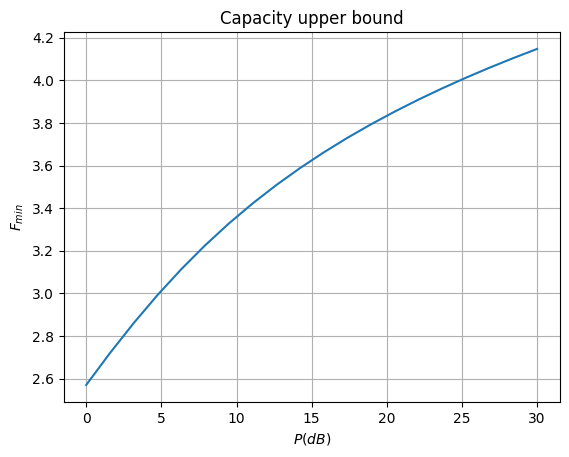

In [ ]:
# Choose a range of V values. Here we use 200 points between 1 and 1000.
nr = 100
P_vals_dB = np.linspace(0, 30, 20)
alpha_opt = []
F_min = []

for P_dB in P_vals_dB:
    P = 10**(P_dB/10)
    a_star, F_star = find_minimum_F(nr, P)
    alpha_opt.append(a_star)
    F_min.append(F_star)

# Plot the minimal value F_min as a function of V
plt.figure()
plt.plot(P_vals_dB, F_min)
plt.title('Capacity upper bound')
plt.xlabel('$P (dB)$')
plt.ylabel('$F_{min}$')
plt.grid(True)
plt.show()

### Compute the bounds for different values of $n_r$

Set $P=20$ dB. Compute and plot the capacity upper bound for $n_r = 1, 10, 50, 100$.

# Ex 2: SIMO with 1-bit ADC

Let us consider a real SIMO channel with $n_r$ receive antennas. Each channel output is $Y_i = \mathrm{sign}(X+Z_i)$ where $Z_i \sim \mathcal{N}(0, \sigma^2)$, $i=1,\ldots,n_r$, are i.i.d. Gaussian noise. The input $X$ is from a standard $M$-PAM constellation, i.e., $\mathcal{X}_M := \{-M+1, -M+3, ..., M-3, M-1\}$. We know that the sufficient statistics of the output for $X$ is the number of $1$'s~(or $-1$'s) among the outputs. Let us call it $T(Y)$.

Therefore, the channel capacity is
$$ C = \max_{P_X} I(P_X, P_{Y|X}) = \max_{P_X} I(P_X, P_{T|X}) $$

In this exercise, we compute the capacity using the Blahut-Arimoto algorithm.

You can use the following headers.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb, erfc

# ---------------------------
# Helper Functions
# ---------------------------
def Q(x):
    """Normal Q function: Q(x)=0.5*erfc(x/sqrt(2))."""
    return 0.5 * erfc(x / np.sqrt(2))

### Build the transition probability matrix $W$

In [ ]:
def build_channel_matrix(x_vals, nr, sigma):
    """
    Given a vector of constellation points x_vals (length M), number of outputs nr, and noise variance
    build the transition probability matrix W of shape (M, n+1) defined by:
      W[m, k] = P(k | x_vals[m])
    """
    M = len(x_vals)
    W = np.zeros((M, nr+1))
    for m in range(M):
        lambda_x = Q(x_vals[m] / sigma)
        for k in range(nr+1):
            W[m, k] = comb(nr, k) * lambda_x**(k) * (1 - lambda_x)**(nr - k)
    return W

### The Blahut-Arimoto algorithm is given below.

In [ ]:
def blahut_arimoto(W, tol=1e-8, max_iter=1000):
    """
    Standard Blahut-Arimoto algorithm for a discrete memoryless channel with channel matrix W.
    W is of shape (M, K) (here K = n+1).

    Returns:
      capacity_nats: the channel capacity in nats.
      p_opt: the optimizing input distribution (length M).
    """
    M, K = W.shape
    # initialize p uniformly
    p = np.ones(M) / M

    for iteration in range(max_iter):
        # Compute the output distribution q(k)
        q = np.dot(p, W)  # shape (K,)

        # Assume W is an array of shape (M, K) and q is of shape (K,)
        epsilon = 1e-15  # a small constant to avoid division by zero

        # For each input symbol m, compute D[m] safely:
        D = np.zeros(M)
        for m in range(M):
            with np.errstate(divide='ignore', invalid='ignore'):
                # Compute the ratio; add epsilon to q to avoid division by exact zero.
                ratio = W[m, :] / (q + epsilon)
                # Only compute the log for entries where W[m, :] > 0; set others to 0.
                log_term = np.where(W[m, :] > 0, np.log(ratio), 0.0)
                # Multiply by W[m, :] (0 * log_term is 0 as desired)
                D[m] = np.sum(W[m, :] * log_term)

        # Update rule: p_new(m) ∝ exp(D(m))
        p_new = np.exp(D)
        p_new = p_new / np.sum(p_new)

        if np.linalg.norm(p_new - p, 1) < tol:
            p = p_new
            break
        p = p_new

    # The capacity is then I = \sum_m p(m) D(m)
    capacity_nats = np.sum(p * D)
    return capacity_nats, p

### Compute the capacity for a given $M$, $n_r$, and $\sigma$

In [ ]:
def comp_capacity(M, nr, sigma):
    """
    For a given M-PAM constellation (with M points), a number of outputs nr, and noise standard deviation sigma
    compute the channel capacity (maximized over input distributions) for the channel

    Returns:
      capacity_bits: Capacity in bits.
    """
    # Define a standard M-PAM constellation.
    # One common choice is to take equally spaced points symmetric about zero.
    # For example, for M=4 we use [-3, -1, 1, 3].
    # Here we choose: x_vals = {-(M-1), -(M-3), ..., M-3, M-1}.
    x_vals = np.arange(-(M-1), M, 2).reshape(-1, 1)

    capacity_bits = []

    # Build the channel matrix
    W = build_channel_matrix(x_vals, nr, sigma)
    # Run Blahut-Arimoto to compute capacity (in nats)
    capacity_nats, p_opt = blahut_arimoto(W)
    # Convert capacity from nats to bits
    capacity_bits = capacity_nats * np.log2(np.e)

    return capacity_bits

### Run the simulation

Let $n_r = [1, 10, 20, ..., 100]$, $M = [2, 4, 8]$, $\sigma = 2$. Plot the capacity versus $n_r$, for different values of $M$.

<ipython-input-13-d412247393fc>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  W[m, k] = comb(nr, k) * lambda_x**(k) * (1 - lambda_x)**(nr - k)


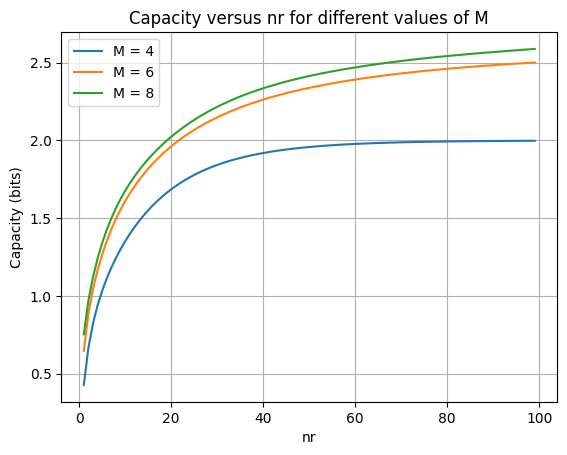

In [ ]:
# ---------------------------
# Plotting: Vary n vs. Capacity for different values of M.
# ---------------------------
n_values = np.arange(1, 100, 1)  # Let's take nr from 1 to 100.
M_list = [4, 6, 8]         # Consider several constellation sizes.
sigma = 2
capacity_bits_list = []
for M in M_list:
    capacity_bits_M = []
    for nr in n_values:
        capacity_bits = comp_capacity(M, nr, sigma)
        capacity_bits_M.append(capacity_bits)
    capacity_bits_list.append(capacity_bits_M)

# Plot the capacity versus nr for different values of M.
for i in range(len(M_list)):
    plt.plot(n_values, capacity_bits_list[i], label=f'M = {M_list[i]}')

plt.xlabel('nr')
plt.ylabel('Capacity (bits)')
plt.title('Capacity versus nr for different values of M')
plt.legend()
plt.grid(True)
plt.show()